In [3]:
%matplotlib inline

import os
import numpy as np

import astropy.io.fits as fits
import astropy.io.ascii as ascii
from astropy import wcs
import astropy.units as u

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc("font", size=14)

## Spot Offsets

Spot centroids have a mean and stochastic offset:
1. A radial mean offset in \$DESIMODEL/data/throughput/DESI-0347_offset.ecsv
2. A random offset in \$DESIMODEL/data/throughput/DESI-0347_random_offset_X.fits, where X=1,2,3

### Lateral Spot Shift vs. Color and Field Angle
See \$DESIMODEL/doc/nb/DESI-0347_Throughput.ipynb

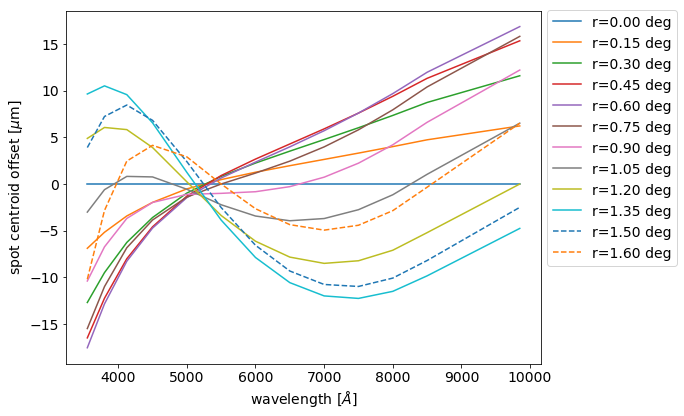

In [4]:
# Mapping of off-axis rays (field angle in deg) to spot centroid offset on focal plane (in um)
# vs. wavelength (in angstroms)
ofsfile = os.environ["DESIMODEL"] + "/data/throughput/DESI-0347_offset.ecsv"
offsets = ascii.read(ofsfile)
offsets

fig, ax = plt.subplots(1,1, figsize=(8,6))
wl = offsets["wavelength"]
for i, ang in enumerate(offsets.colnames[1:]):
    ls = "-" if i < 10 else "--"
    xy = offsets[ang]
    ax.plot(wl, xy, ls=ls, label=ang)
ax.set(xlabel=r"wavelength [$\AA$]",
       ylabel=r"spot centroid offset [$\mu$m]")
ax.legend(bbox_to_anchor=(0.3, 0.92, 1., .102))
fig.tight_layout();

### Random Offsets

These are random realizations of spot centroid offsets. See \$DESIMODEL/doc/nb/DESI-0347_Throughput.ipynb

8.37530460358
8.2043756485
8.2368188858


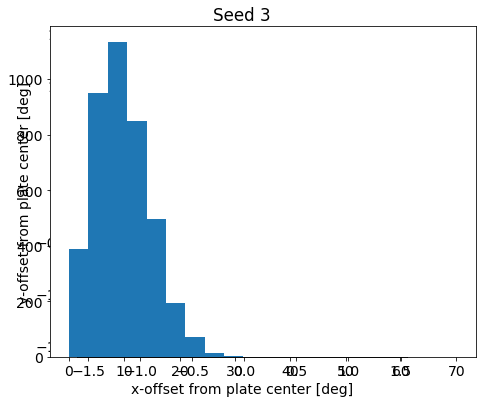

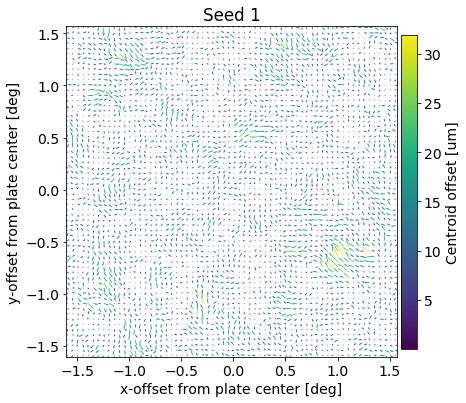

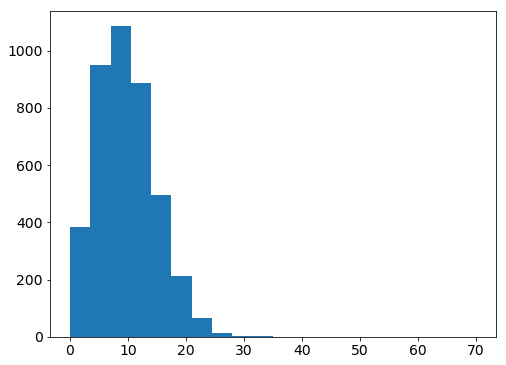

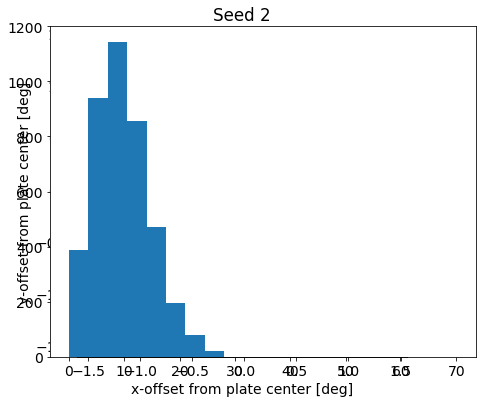

In [5]:
def plot_random_offsets(seed=2, subsampling=4, save=None):

    hdus = fits.open(os.environ["DESIMODEL"] + ("/data/throughput/DESI-0347_random_offset_%d.fits" % seed))

    # Extract the offset images.
    dx = hdus['XOFFSET'].data
    dy = hdus['YOFFSET'].data
    dr = np.sqrt(dx ** 2 + dy ** 2)
    
    # Reconstruct the linear WCS.
    hdr = hdus[1].header
    w = wcs.WCS(hdr)
    nxy = len(dx)
    pix = np.arange(nxy)
    xlo, ylo, xhi, yhi = w.wcs_pix2world([[0, 0], [nxy - 1, nxy - 1]], 0).flatten()
    assert xlo == ylo and xhi == yhi
    xy = np.linspace(xlo, xhi, nxy)
    xy_pad = hdr['CDELT1']
    unit = u.Unit(hdr['BUNIT'])
    
    # Downsample.
    dx = dx[::subsampling, ::subsampling]
    dy = dy[::subsampling, ::subsampling]
    dr = dr[::subsampling, ::subsampling]
    xy = xy[::subsampling]

    fig, ax = plt.subplots(1,1, figsize=(7, 5.83))
    img = ax.quiver(xy, xy, dx, dy, dr, headwidth=1.5, headlength=2.)
    ax.set(xlim=(xy[0] - xy_pad, xy[-1] + xy_pad),
           ylim=(xy[0] - xy_pad, xy[-1] + xy_pad),
           xlabel='x-offset from plate center [deg]',
           ylabel='y-offset from plate center [deg]',
           title='Seed {0}'.format(seed),
           aspect='equal')
    fig.colorbar(img, pad=0.01, shrink=0.95).set_label(
        'Centroid offset [{0}]'.format(unit))
    fig.tight_layout()
    fig.savefig("random_offsets_{0}.png".format(seed))
    
#     fig, ax = plt.subplots(1,1, figsize=(8,6))
#     ax.hist(dr, bins=20)
    fig = plt.figure(seed+5, figsize=(8,6))
    ax = fig.add_subplot(111)
    ax.hist(dr.flatten(), bins=np.linspace(0,70,21))
    print(np.percentile(np.sqrt(dx ** 2/2 + dy ** 2/2), 68))
    
plot_random_offsets(1)
plot_random_offsets(2)
plot_random_offsets(3)

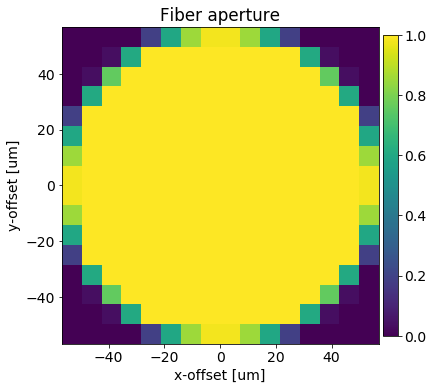

In [6]:
hdus = fits.open("fiberloss.fits.1")
data = hdus[1].data
nxy = len(data)

hdr = hdus[1].header
w = wcs.WCS(hdr)
xlo, ylo, xhi, yhi = w.wcs_pix2world([[0, 0], [nxy - 1, nxy - 1]], 0).flatten()
assert xlo == ylo and xhi == yhi
xy = np.linspace(xlo, xhi, nxy)
xy_pad = hdr['CDELT1']
info = hdr['COMMENT'][-1]

fig, ax = plt.subplots(1,1, figsize=(7, 5.83))
img = ax.imshow(data,
                extent=[xy[0] - xy_pad,
                        xy[-1] + xy_pad,
                        xy[0] - xy_pad,
                        xy[-1] + xy_pad])
ax.set(xlabel='x-offset [um]',
       ylabel='y-offset [um]',
       title=info,
       aspect='equal')

cb = fig.colorbar(img, pad=0.01, shrink=0.95)

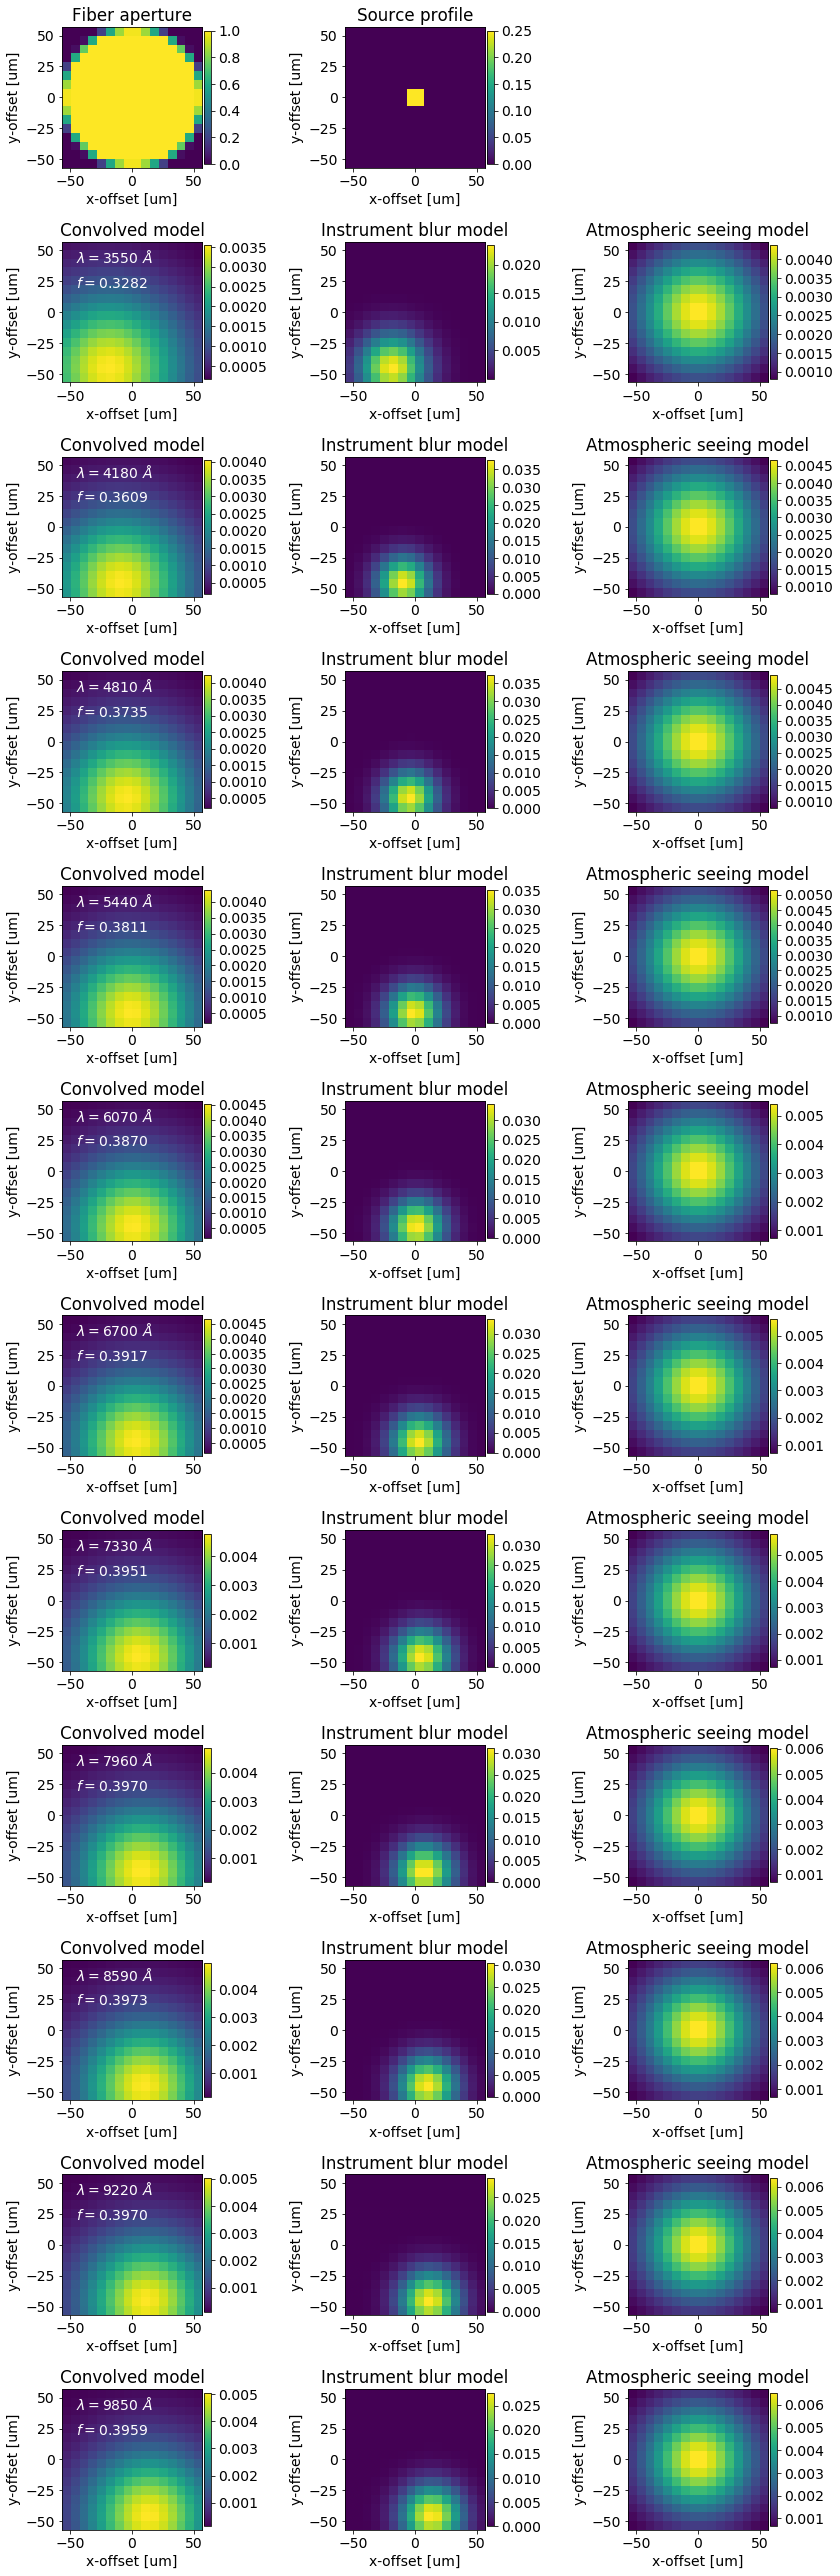

In [10]:
hdus = fits.open("fiberloss.fits.2")
N = len(hdus)

# Calculate some fancy rows and columns.
# First table is just file info. Second table is fiber aperture. Last table is source.
ncol = 3
nrow = int((N-3)/ncol + 1)

fig, axr = plt.subplots(nrow, ncol, figsize=(12,36))#, sharex=True, sharey=True)
axes = axr.flatten()

# This should plot the fiber aperture and source profile.
for i, j in zip([1, N-1], [0,1]):
    head = hdus[i].header
    data = hdus[i].data
    info = head["COMMENT"][-1]
    
    nxy = len(data)
    w = wcs.WCS(head)
    xlo, ylo, xhi, yhi = w.wcs_pix2world([[0, 0], [nxy - 1, nxy - 1]], 0).flatten()
    assert xlo == ylo and xhi == yhi
    xy = np.linspace(xlo, xhi, nxy)
    xy_pad = head['CDELT1']
        
    img = axes[j].imshow(data,
                         extent=[xy[0] - xy_pad,
                                 xy[-1] + xy_pad,
                                 xy[0] - xy_pad,
                                 xy[-1] + xy_pad])
    axes[j].set(title=info,
                adjustable='box-forced',
                aspect='equal',
                xlabel="x-offset [um]",
                ylabel="y-offset [um]")
    cb = fig.colorbar(img, ax=axes[j], pad=0.01, shrink=0.95)
axes[2].axis("off")

# This should plot convolved results
for i in range(2, N-1):
    head = hdus[i].header
    data = hdus[i].data
    info = head["COMMENT"][-1]
    wl = head["WLEN"]
    fr = head["FRAC"]
    
    nxy = len(data)
    w = wcs.WCS(head)
    xlo, ylo, xhi, yhi = w.wcs_pix2world([[0, 0], [nxy - 1, nxy - 1]], 0).flatten()
    assert xlo == ylo and xhi == yhi
    xy = np.linspace(xlo, xhi, nxy)
    xy_pad = head['CDELT1']
    
    img = axes[i+1].imshow(data,
                           extent=[xy[0] - xy_pad,
                                 xy[-1] + xy_pad,
                                 xy[0] - xy_pad,
                                 xy[-1] + xy_pad])
    axes[i+1].set(title=info,
                  adjustable='box-forced',
                  aspect='equal',
                  xlabel="x-offset [um]",
                  ylabel="y-offset [um]")
    
    if (i+1)%3 == 0 and i>0:
        axes[i+1].text(-45,40, r'$\lambda={:g}$ $\AA$'.format(wl), color="w")
        axes[i+1].text(-45,20, r'$f={:.4f}$'.format(fr), color="w")
    cb = fig.colorbar(img, ax=axes[i+1], pad=0.01, shrink=0.95)

fig.tight_layout();
fig.savefig("fiberloss.pdf")

FileNotFoundError: [Errno 2] No such file or directory: 'fiberloss.0mm.ecsv.1'

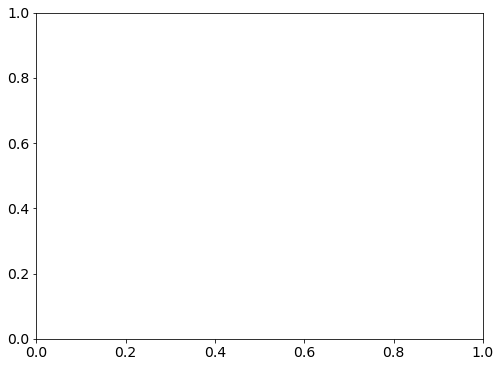

In [11]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
# for seed in range(1,4):
#     data = ascii.read("fiberloss.ecsv.{0}".format(seed))
#     wl = data["Wavelength"]
#     fr = data["FiberAcceptance"]
#     ax.plot(wl, fr, label="Seed {0}".format(seed))
#     ax.set(xlabel="wavelength [{0}]".format(wl.unit),
#            ylabel="fiber acceptance")

for off in range(0,60,10):
    data = ascii.read("fiberloss.{0}mm.ecsv.1".format(off))
    wl = data["Wavelength"]
    fr = data["FiberAcceptance"]
    style = "r-"
    ax.plot(wl, fr, style, alpha=0.3, label='')#, label="Seed 1 (offset {0},{0} mm)".format(off))
    
for off in range(100,160,10):
    data = ascii.read("fiberloss.{0}mm.ecsv.1".format(off))
    wl = data["Wavelength"]
    fr = data["FiberAcceptance"]
    style = "b-"
    ax.plot(wl, fr, style, alpha=0.3, label='')#, label="Seed 1 (offset {0},{0} mm)".format(off))
    
for off in range(200,260,10):
    data = ascii.read("fiberloss.{0}mm.ecsv.1".format(off))
    wl = data["Wavelength"]
    fr = data["FiberAcceptance"]
    style = "g-"
    ax.plot(wl, fr, style, alpha=0.3, label='')#, label="Seed 1 (offset {0},{0} mm)".format(off))
    
ax.set(xlabel="wavelength [{0}]".format(wl.unit),
       ylabel="fiber acceptance")
ax.legend(bbox_to_anchor=[1,0.95])
fig.tight_layout();

## Generation of Random Vector Fields

10.886
0.00274018664663 0.00292512451889 1.06749097638 1.0712667735
5.13967330703 11.6207067689


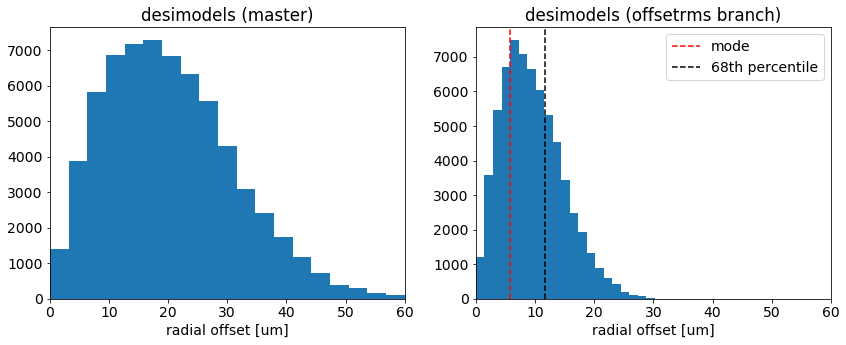

In [195]:
def generate_random_vector_field(rms, exponent, n, seed=None, smoothing=0.05, oldrms=False):
    """Generate a pair dx, dy of 2D Gaussian random field.

    The random field is generated with a power spectrum P(k) ~ r ** exponent
    and normalized to the specified RMS value.  Smoothing is applied to minimize
    grid artifacts.

    Parameters
    ----------
    rms : float or astropy quantity
        Desired RMS of the generated field values.
    exponent : float
        Exponent of the power spectrum scaling with radius.
    n : int
        Size of the generated array along each axis.
    seed : int
        Random number seed to use. Generated fields should be portable
        across python versions and platforms.
    smoothing : float
        Length scale for smoothing the generated field expressed
        as a fraction of the full width of the field.  Implemented
        as a Gaussian convolution.  No smoothing is applied when
        smoothing is zero.

    Returns
    -------
    tuple
        Tuple dx, dy of 2D arrays containing the generated Gaussian
        random field values. Arrays will have the same units as the
        rms parameter, if any.
    """
    A = np.zeros((n, n), complex)
    kvec = np.fft.fftfreq(n)
    kx, ky = np.meshgrid(kvec, kvec, sparse=True, copy=False)
    ksq = kx ** 2 + ky ** 2
    m = ksq > 0
    gen = np.random.RandomState(seed=seed)
    phase = 2 * np.pi * gen.uniform(size=(n, n))
    A[m] = (ksq[m] ** (exponent / 2) * gen.normal(size=(n, n))[m] *
            np.exp(1.j * phase[m]))
    if smoothing > 0:
        var = (n * smoothing) ** 2 / 2
        A[m] *= np.exp(-ksq[m] * var) / (2 * np.pi)
    offsets = np.fft.ifft2(A)

    # Rescale to the specified RMS radial offset.
    if oldrms:
        rescale = rms / np.std(np.sqrt(offsets.real ** 2 + offsets.imag ** 2))
    else:
        dr2 = (offsets.real**2 + offsets.imag**2).flatten()
        rescale = rms / np.sqrt(np.var(offsets.real) + np.var(offsets.imag))
        corr1 = np.sqrt(np.average(dr2))
        dr = np.sqrt(dr2)
        corr2 = np.percentile(dr, 68)
        
        print(corr1, corr2, corr2/corr1, 1.515 / np.sqrt(2))
#         dr = np.sqrt(offsets.real ** 2 + offsets.imag ** 2).flatten()
#         rescale = rms / np.percentile(dr, 68)
    dx = offsets.real * rescale
    dy = offsets.imag * rescale

    return dx, dy

fig, ax = plt.subplots(1, 2, figsize=(14,5))

dx, dy = generate_random_vector_field(10.886, -1., 256, seed=None, smoothing=0.05, oldrms=True)
dr = np.sqrt(dx**2 + dy**2).flatten()
n, bins, p = ax[0].hist(dr, bins=21)
print(np.std(dr))
ax[0].set_xlabel("radial offset [um]");
ax[0].set_title("desimodels (master)")
ax[0].set_xlim(0,60)

# dx, dy = generate_random_vector_field(10.886, -1., 256, seed=None, smoothing=0.05)
dx, dy = generate_random_vector_field(10.886, -1., 256, seed=None, smoothing=0.05)
dr = np.sqrt(dx**2 + dy**2).flatten()
pct68 = np.percentile(dr, 68)

print(np.std(dr), pct68)
n, bins, p = ax[1].hist(dr, bins=21)
mode = bins[np.argmax(n)]

ax[1].set_title("desimodels (offsetrms branch)")
ax[1].axvline(mode, color="r", ls="--", label="mode")
ax[1].axvline(pct68, color="k", ls="--", label="68th percentile")
ax[1].set_xlabel("radial offset [um]");
ax[1].set_xlim(0,60)
ax[1].legend();

fig.savefig("offsetrms.png")

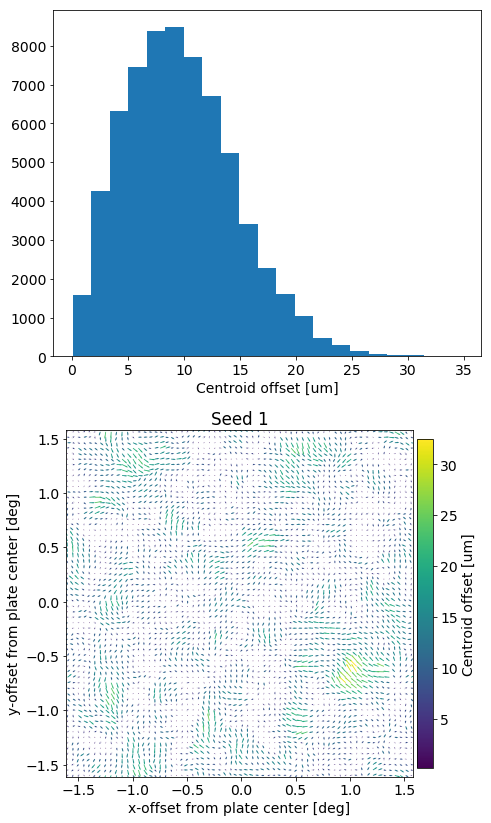

In [17]:
# Double check desimodels:
from desimodel import focalplane

dx, dy = focalplane.generate_random_vector_field(10.886, -1., 256, seed=1, smoothing=0.05)
dr = np.sqrt(dx ** 2 + dy ** 2)
    
nxy = len(dx)
xlo, ylo, xhi, yhi = -1.6, -1.6, 1.6, 1.6
xy = np.linspace(xlo, xhi, nxy)
xy_pad = (xhi - xlo) / nxy

fig, [ax0,ax1] = plt.subplots(2,1, figsize=(7, 11.66))

ax0.hist(dr.flatten(), bins=21)
ax0.set(xlabel="Centroid offset [um]")

# Downsample.
subsampling = 4
dx = dx[::subsampling, ::subsampling]
dy = dy[::subsampling, ::subsampling]
dr = dr[::subsampling, ::subsampling]
xy = xy[::subsampling]

img = ax1.quiver(xy, xy, dx, dy, dr, headwidth=1.5, headlength=2.)
ax1.set(xlim=(xy[0] - xy_pad, xy[-1] + xy_pad),
       ylim=(xy[0] - xy_pad, xy[-1] + xy_pad),
       xlabel='x-offset from plate center [deg]',
       ylabel='y-offset from plate center [deg]',
       title='Seed {0}'.format(1),
       aspect='equal')
fig.colorbar(img, ax=ax1, pad=0.01, shrink=0.95).set_label('Centroid offset [um]')
fig.tight_layout();